#Environment (Run)

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
!pip install transformers
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.0 MB/s 
     |████████████████████████████████| 596 kB 74.3 MB/s 
     |████████████████████████████████| 6.6 MB 56.9 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Gen RAM Free: 12.3 GB  | Proc size: 96.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
#import library
import numpy as np
import pandas as pd

In [ ]:
#import torch and check cuda
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#Dataset

In [ ]:
# Upload data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
traindata = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/Preprocessing/random oversampling result/Preprocessing Upsampling Result for Oversampling random over majority class Agreement Reply Januari New 2022.xlsx')
traindata.shape

(22016, 15)

In [ ]:
traindata_agreement = traindata[['username', 'tweet', 'text_reply', 'Agreement Reply']]
traindata_agreement = traindata_agreement.loc[traindata_agreement['tweet'].notnull()]
traindata_agreement = traindata_agreement.loc[traindata_agreement['text_reply'].notnull()]
traindata_agreement['Agreement Reply'] = traindata_agreement['Agreement Reply'].replace(-1, 2)

In [ ]:
print(traindata_agreement.shape)
print(traindata_agreement.isnull().sum())
print(traindata_agreement['Agreement Reply'].value_counts())

(22016, 4)
username           0
tweet              0
text_reply         0
Agreement Reply    0
dtype: int64
2    7435
1    7371
0    7210
Name: Agreement Reply, dtype: int64


In [ ]:
testdata = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/Preprocessing/Preprocessing for oversampling/Preprocessing Result for Oversampling random over majority class Februari New 2022.xlsx")

In [ ]:
testdata = testdata.loc[testdata['text_reply'].notnull()]
testdata = testdata.loc[testdata['tweet'].notnull()]
print(testdata.isnull().sum())

username         0
id_tweet_ori     0
date             0
time             0
replies_count    0
likes_count      0
retweet_count    0
tweet            0
text_reply       0
dtype: int64


In [ ]:
# print(traindata_sentiment.shape,testdata.shape)
# print(traindata_sentiment.isnull().sum())
# print(testdata_sentiment.isnull().sum())

#BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1", do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
sentences_1 = traindata_agreement['tweet'].to_list()
sentences_2 = traindata_agreement['text_reply'].to_list()
labels = traindata_agreement['Agreement Reply'].astype(int).values

In [ ]:
test_sentences_1 = testdata['tweet'].to_list()
test_sentences_2 = testdata['text_reply'].to_list()

In [ ]:
import pickle
import os
from torch.nn.utils.rnn import pad_sequence


token_ids = []
mask_ids = []
seg_ids = []

for (tweet, reply) in zip(sentences_1, sentences_2):
  tweet_input_id = tokenizer.encode(tweet, add_special_tokens = False)
  reply_input_id = tokenizer.encode(reply, add_special_tokens = False)
  pair_token_ids = [tokenizer.cls_token_id] + tweet_input_id + [tokenizer.sep_token_id] + reply_input_id + [tokenizer.sep_token_id]
  tweet_len = len(tweet_input_id)
  reply_len = len(reply_input_id)
  segment_ids = torch.tensor([0] * (tweet_len + 2) + [1] * (reply_len + 1))  # sentence 0 and sentence 1
  attention_mask_ids = torch.tensor([1] * (tweet_len + reply_len + 3))  # mask padded values

  token_ids.append(torch.tensor(pair_token_ids))
  seg_ids.append(segment_ids)
  mask_ids.append(attention_mask_ids)

token_ids = pad_sequence(token_ids, batch_first=True)
mask_ids = pad_sequence(mask_ids, batch_first=True)
seg_ids = pad_sequence(seg_ids, batch_first=True)

In [ ]:
print("Token ids: " , token_ids[0])
print("Segment ids: " , seg_ids[0])
print("Attention Mask ids: " , mask_ids[0])

Token ids:  tensor([    2,   232,  1594,   975,  8231,  1282,  4097,  6567,  2234,  6567,
          407,  5921,  1798,   825,  3424,  3406,     3,  4043,  1966,  1883,
         2076,  4142,    88,   176,  2962,   245,   119,    34,  2999, 12726,
        30359,  1921, 30359,   599,   436,  6567,   154, 14261, 11682,   259,
         2609,   633,   384,  6875,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Gabungkan setiap token (input training) menjadi TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Bagi data 80-20 train-validation split.
# Hitung jumlah sampel pada masing-masing split size
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Bagi secara random data untuk train dan val tanpa ada yang tumpang tindih
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

17,612 training samples
4,404 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Set batch_size 32 https://link.springer.com/article/10.1007/s10660-022-09560-w
''' BERT authors recommend the hyperparameters used for fine-tuning [22]. 
For training and validation of classifiers developed with sequence lengths of 64, 128, 256, and 320,
 a batch size of 32 is used. For fine-tuning BERT, the authors recommend batch sizes of 16 and 32 '''
batch_size = 32

# Buat DataLoader untuk train dan val set untuk mengatur batching dan sampling
# Training sample diambil urutannya secara acak (agar dalam satu batch diharapkan sample bervariasi)
train_dataloader = DataLoader(
            train_dataset,  # The training samples
            sampler = RandomSampler(train_dataset), # Pilih sample batch secara random
            batch_size = batch_size # Train dengan jumlah batch size 32
        )

# Validation sample diambil secara berurutan (karena urutan sudah tidak penting lagi)
validation_dataloader = DataLoader(
            val_dataset, # The validation samples
            sampler = SequentialSampler(val_dataset), # Pilih sample batch secara sequential (urut)
            batch_size = batch_size # Evaluasi dengan jumlah batch size 32
        )

#Training

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel
# Load BertForSequenceClassification: the pretrained BERT model with single linear classification layer on top 
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", 
    num_labels = 3, #jumlah label
    output_attentions = False, # tidak return attentions weights
    output_hidden_states = False, # tidak returns all hidden-states
)

# Run model di GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

learning rate dan epsilon mengikuti eksperimen penelitian lalu
https://docs.google.com/document/d/1BFZQx3uELgcoDQVa8sMNKhbAaMXtx3Vjb2DZ6Uayci4/edit

In [ ]:
from transformers import AdamW

#AdamW optimizer dengan weight decay untuk menurunkan kemungkinan overfitting
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total jumlah training steps = [Jumlah batch] x [Jumlah epochs]
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Warmup explanation https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning,
# https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup
# num_warmup_steps default 0
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Jumlah batch : 551


## Training

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import numpy as np

# Hitung akurasi prediksi vs label
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
y_true_val=[]
y_pred_val = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0
  train_accuracy = 0
  model.train()

  # Untuk setiap batch
  for step, batch in enumerate(train_dataloader):
    
    # Progress update setiap 10 batches
    if step % 10 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    pair_token_ids = batch[0].to(device)
    mask_ids = batch[1].to(device)
    seg_ids = batch[2].to(device)
    labels = batch[3].to(device)

    model.zero_grad()

    loss, pred = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            labels=labels).values()
    # loss = outputs[0]
    # pred = outputs[1]
    pred = pred.detach().cpu().numpy()
    total_loss += loss.item()

    loss.backward()
    label_ids = labels.to('cpu').numpy()

    tmp_train_accuracy = flat_accuracy(pred, label_ids)

    train_accuracy += tmp_train_accuracy

    step += 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Accuracy: {0:.2f}".format(train_accuracy/step))
  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    pair_token_ids, mask_ids,seg_ids, labels = batch

    with torch.no_grad():
      outputs = model(pair_token_ids, 
                      token_type_ids=seg_ids, 
                      attention_mask=mask_ids) 
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
    if epoch_i==9:
      y_pred_val.append(logits)
      y_true_val.append(label_ids)
  
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch    10 of   551.     Elapsed: 0:00:04
Batch    20 of   551.     Elapsed: 0:00:08
Batch    30 of   551.     Elapsed: 0:00:13
Batch    40 of   551.     Elapsed: 0:00:17
Batch    50 of   551.     Elapsed: 0:00:21
Batch    60 of   551.     Elapsed: 0:00:25
Batch    70 of   551.     Elapsed: 0:00:29
Batch    80 of   551.     Elapsed: 0:00:34
Batch    90 of   551.     Elapsed: 0:00:38
Batch   100 of   551.     Elapsed: 0:00:42
Batch   110 of   551.     Elapsed: 0:00:46
Batch   120 of   551.     Elapsed: 0:00:51
Batch   130 of   551.     Elapsed: 0:00:55
Batch   140 of   551.     Elapsed: 0:00:59
Batch   150 of   551.     Elapsed: 0:01:03
Batch   160 of   551.     Elapsed: 0:01:07
Batch   170 of   551.     Elapsed: 0:01:12
Batch   180 of   551.     Elapsed: 0:01:16
Batch   190 of   551.     Elapsed: 0:01:20
Batch   200 of   551.     Elapsed: 0:01:24
Batch   210 of   551.     Elapsed: 0:01:29
Batch   220 of   551.     Elapsed: 0:01:33
Batch   230 o

In [ ]:
# def multi_acc(y_pred, y_test):
#   acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
#   return acc

# import time

# EPOCHS = 10

# loss_values = []
# y_true_val=[]
# y_pred_val = []

# total_step = len(train_dataloader)

# for epoch in range(EPOCHS):
#   start = time.time()
#   model.train()
#   total_train_loss = 0
#   total_train_acc  = 0
#   for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_dataloader):
#     optimizer.zero_grad()
#     pair_token_ids = pair_token_ids.to(device)
#     mask_ids = mask_ids.to(device)
#     seg_ids = seg_ids.to(device)
#     labels = y.to(device)

#     loss, prediction = model(pair_token_ids, 
#                             token_type_ids=seg_ids, 
#                             attention_mask=mask_ids, 
#                             labels=labels).values()

#     acc = multi_acc(prediction, labels)

#     loss.backward()
#     optimizer.step()
    
#     total_train_loss += loss.item()
#     total_train_acc  += acc.item()

#   avg_train_loss = total_train_loss / len(train_dataloader)
#   loss_values.append(avg_train_loss)

#   train_acc  = total_train_acc/len(train_dataloader)
#   train_loss = total_train_loss/len(train_dataloader)
#   model.eval()
#   total_val_acc  = 0
#   total_val_loss = 0
#   with torch.no_grad():
#     for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(validation_dataloader):
#       optimizer.zero_grad()
#       pair_token_ids = pair_token_ids.to(device)
#       mask_ids = mask_ids.to(device)
#       seg_ids = seg_ids.to(device)
#       labels = y.to(device)
      
#       loss, prediction = model(pair_token_ids, 
#                             token_type_ids=seg_ids, 
#                             attention_mask=mask_ids, 
#                             labels=labels).values()
      
#       acc = multi_acc(prediction, labels)

#       logits = prediction
#       logits = logits.detach().cpu().numpy()
#       b_labels = labels.to('cpu').numpy()

#       y_pred_val.append(logits)
#       y_true_val.append(b_labels)

#       total_val_loss += loss.item()
#       total_val_acc  += acc.item()

#   val_acc  = total_val_acc/len(validation_dataloader)
#   val_loss = total_val_loss/len(validation_dataloader)
#   end = time.time()
#   hours, rem = divmod(end-start, 3600)
#   minutes, seconds = divmod(rem, 60)

#   print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
#   print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1: train_loss: 0.6600 train_acc: 0.7316 | val_loss: 0.5541 val_acc: 0.7802
00:02:05.60
Epoch 2: train_loss: 0.5123 train_acc: 0.8096 | val_loss: 0.5394 val_acc: 0.7947
00:02:05.37
Epoch 3: train_loss: 0.3928 train_acc: 0.8604 | val_loss: 0.5792 val_acc: 0.7940
00:02:05.25
Epoch 4: train_loss: 0.2769 train_acc: 0.9080 | val_loss: 0.6833 val_acc: 0.7902
00:02:05.28
Epoch 5: train_loss: 0.1920 train_acc: 0.9362 | val_loss: 0.8193 val_acc: 0.7573
00:02:05.23
Epoch 6: train_loss: 0.1382 train_acc: 0.9519 | val_loss: 0.8789 val_acc: 0.7877
00:02:05.25
Epoch 7: train_loss: 0.0879 train_acc: 0.9681 | val_loss: 0.9356 val_acc: 0.7706
00:02:05.21
Epoch 8: train_loss: 0.0544 train_acc: 0.9823 | val_loss: 1.0657 val_acc: 0.7774
00:02:05.21
Epoch 9: train_loss: 0.0530 train_acc: 0.9824 | val_loss: 1.0845 val_acc: 0.7605
00:02:05.25
Epoch 10: train_loss: 0.0356 train_acc: 0.9891 | val_loss: 1.1478 val_acc: 0.7702
00:02:05.88


## Performance Evaluation (Don't Run It)

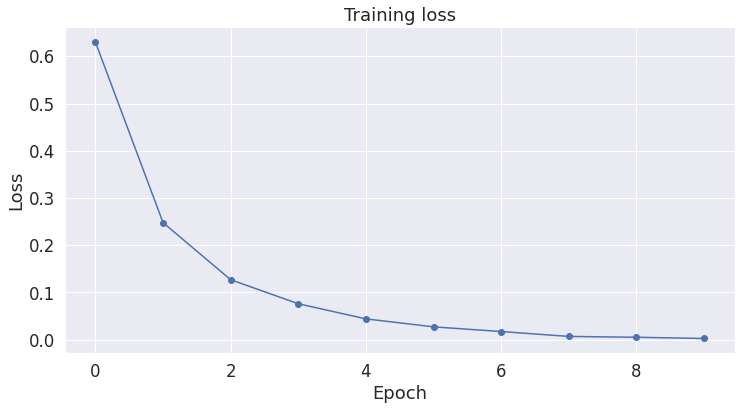

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
import sklearn.metrics as skm
import numpy as np

y_pred_val = np.concatenate(y_pred_val, axis=0)
y_pred_val = np.argmax(y_pred_val, axis=1).flatten()


y_true_val = np.concatenate(y_true_val, axis=0)


print(len(y_pred_val))
print(len(y_true_val))

4404
4404


In [ ]:
cm = skm.multilabel_confusion_matrix(y_true_val, y_pred_val)
print(cm)
print(skm.classification_report(y_true_val, y_pred_val))

[[[2794  170]
  [ 112 1328]]

 [[2863  108]
  [ 215 1218]]

 [[2824   49]
  [   0 1531]]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1440
           1       0.92      0.85      0.88      1433
           2       0.97      1.00      0.98      1531

    accuracy                           0.93      4404
   macro avg       0.92      0.92      0.92      4404
weighted avg       0.93      0.93      0.93      4404



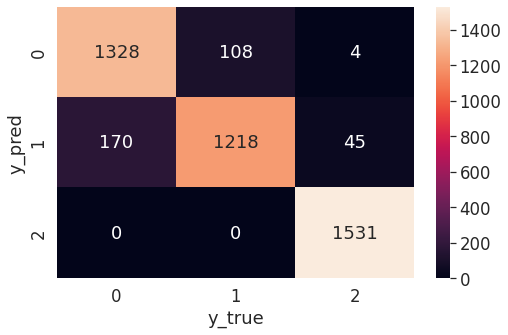

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true_val, y_pred_val), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.show()

# Predict

In [ ]:
import pickle
import os
from torch.nn.utils.rnn import pad_sequence


token_ids = []
mask_ids = []
seg_ids = []

for (tweet, reply) in zip(test_sentences_1, test_sentences_2):
  tweet_input_id = tokenizer.encode(tweet, add_special_tokens = False)
  reply_input_id = tokenizer.encode(reply, add_special_tokens = False)
  pair_token_ids = [tokenizer.cls_token_id] + tweet_input_id + [tokenizer.sep_token_id] + reply_input_id + [tokenizer.sep_token_id]
  tweet_len = len(tweet_input_id)
  reply_len = len(reply_input_id)
  segment_ids = torch.tensor([0] * (tweet_len + 2) + [1] * (reply_len + 1))  # sentence 0 and sentence 1
  attention_mask_ids = torch.tensor([1] * (tweet_len + reply_len + 3))  # mask padded values

  token_ids.append(torch.tensor(pair_token_ids))
  seg_ids.append(segment_ids)
  mask_ids.append(attention_mask_ids)

token_ids = pad_sequence(token_ids, batch_first=True)
mask_ids = pad_sequence(mask_ids, batch_first=True)
seg_ids = pad_sequence(seg_ids, batch_first=True)

from torch.utils.data import TensorDataset, random_split


prediction_data = TensorDataset(token_ids, mask_ids, seg_ids)

batch_size = 1
prediction_dataloader = DataLoader(prediction_data, shuffle = True, batch_size = batch_size)


In [ ]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 7775


In [ ]:
import time

model.eval()

predictions = []
total_step = len(prediction_dataloader)

with torch.no_grad():
  for batch_idx, (pair_token_ids, mask_ids, seg_ids) in enumerate(prediction_dataloader):
    optimizer.zero_grad()
    pair_token_ids = pair_token_ids.to(device)
    mask_ids = mask_ids.to(device)
    seg_ids = seg_ids.to(device)
    
    prediction = model(pair_token_ids, 
                      token_type_ids=seg_ids, 
                      attention_mask=mask_ids)

    logits = prediction[0]
    logits = logits.detach().cpu().numpy()

    predictions.append(logits)

print('DONE')

DONE


In [ ]:
# # Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# # Ubah model jadi mode evaluasi
# model.eval()

# predictions = []

# for batch in prediction_dataloader:
#   # Tambah batch ke GPU
#   batch = tuple(t.to(device) for t in batch)
  
#  # Unpack inputs dari dataloader
#   pair_token_ids, seg_ids, mask_ids = batch
  
#  # Untuk prediksi gradien tidak dihitung atau disimpan (autograd dimatikan) untuk saving memory dan mempercepat prediksi
#   with torch.no_grad():
#       # Hitung logit predictions
#       outputs = model(pair_token_ids, token_type_ids=seg_ids, 
#                       attention_mask=mask_ids)

#   logits = outputs[0]

#   # Pindah logits dan label ke CPU
#   logits = logits.detach().cpu().numpy()
  
#   # Simpan prediksi
#   predictions.append(logits)

# print('    DONE.')

In [ ]:
predictions

[array([[ 1.3294172,  3.1620936, -5.15608  ]], dtype=float32),
 array([[ 0.42589098,  3.9952264 , -4.53952   ]], dtype=float32),
 array([[ 2.808477 ,  2.1831777, -5.071743 ]], dtype=float32),
 array([[ 1.0430409,  3.8461404, -5.3379636]], dtype=float32),
 array([[-0.6956077,  5.0647407, -4.812265 ]], dtype=float32),
 array([[-0.08594038,  5.0006986 , -5.491225  ]], dtype=float32),
 array([[ 4.3036447,  1.2155209, -6.298382 ]], dtype=float32),
 array([[ 5.9828353, -3.3665285, -2.6710458]], dtype=float32),
 array([[-0.67541176,  5.8124723 , -5.759423  ]], dtype=float32),
 array([[ 6.6137195, -3.0596895, -3.871797 ]], dtype=float32),
 array([[ 2.86883  ,  2.4772458, -5.772639 ]], dtype=float32),
 array([[-2.8145468,  6.1829696, -3.6371522]], dtype=float32),
 array([[ 7.021973 , -2.8504028, -4.8605   ]], dtype=float32),
 array([[ 4.466798  ,  0.24199162, -6.1007524 ]], dtype=float32),
 array([[-0.13767345,  4.773724  , -4.677785  ]], dtype=float32),
 array([[ 0.14607583,  5.1575446 , -6.08

In [ ]:
np.shape(predictions)

(7775, 1, 3)

In [ ]:
predictions = np.concatenate(predictions, axis=0)

In [ ]:
data_result = pd.DataFrame(predictions, columns=['AGREEMENT REPLY RANDOM', 'AGREEMENT REPLY AGREE', 'AGREEMENT REPLY DISAGREE'])

In [ ]:
dfhasilpredict = data_result.eq(data_result.where(data_result != 0).max(1), axis=0).astype(int)
dfhasilpredict

,AGREEMENT REPLY RANDOM,AGREEMENT REPLY AGREE,AGREEMENT REPLY DISAGREE
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0
...,...,...,...
7770,0,1,0
7771,0,1,0
7772,0,1,0
7773,0,1,0


In [ ]:
print(testdata.shape)
print(dfhasilpredict.shape)

(7775, 9)
(7775, 3)


In [ ]:
finalresult = pd.concat([testdata.reset_index(), dfhasilpredict.reset_index()], axis=1, sort=False)
finalresult = finalresult.drop('index', axis=1)
finalresult

,username,id_tweet_ori,date,time,replies_count,likes_count,retweet_count,tweet,text_reply,AGREEMENT REPLY RANDOM,AGREEMENT REPLY AGREE,AGREEMENT REPLY DISAGREE
0,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10.0,265.0,71.0,titip salam ke guru kamu bahwa covid19 itu pen...,karena dalam islam diajarkan ketika kamu perca...,0,1,0
1,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10.0,265.0,71.0,titip salam ke guru kamu bahwa covid19 itu pen...,saya kebetulan juga guru agama ners eh tapi sa...,0,1,0
2,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10.0,265.0,71.0,titip salam ke guru kamu bahwa covid19 itu pen...,ada juga yang aneh masih keluarga ku capek ban...,1,0,0
3,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10.0,265.0,71.0,titip salam ke guru kamu bahwa covid19 itu pen...,orang kayak begini meski sudah kena juga akan ...,0,1,0
4,afrkml,1.489401e+18,2022-02-04,00:52:05+00:00,10.0,265.0,71.0,titip salam ke guru kamu bahwa covid19 itu pen...,berbisnis yang tidak mementingkan kesehatan da...,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7770,mbahndi,1.494559e+18,2022-02-18,06:27:00+00:00,2.0,64.0,22.0,banyak pasien muda antara usia 2025 tahun yang...,kalau saya biasanya karena takut terhadap sesu...,0,1,0
7771,mbahndi,1.494559e+18,2022-02-18,06:27:00+00:00,2.0,64.0,22.0,banyak pasien muda antara usia 2025 tahun yang...,mungkin yang tidak tahu penyebabnya makin kura...,0,1,0
7772,mbahndi,1.494522e+18,2022-02-18,04:01:21+00:00,2.0,7.0,0.0,dua belas tahun yang lalu saya menulis notes i...,namanya juga usaha berdoa cengiran,0,1,0
7773,mbahndi,1.494522e+18,2022-02-18,04:01:21+00:00,2.0,7.0,0.0,dua belas tahun yang lalu saya menulis notes i...,masih awal tahun 2010 saya masih 3 sama belum ...,0,1,0


In [ ]:
from google.colab import files
finalresult.to_excel('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/result/Predict Result Agreement Reply Random Oversampling Februari New 2022.xlsx', index=False) 


#Save Model

In [ ]:
filepath = '/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Data Twitter/indobertindobenchmarkagreementreply.pth'
torch.save(model, filepath)